# Bundle Adjustment

Part of this assignment is based on scipy-cookbook. It will take around 2 hours to finish.

# Question 1: Reading

1. Read the paper 'Building Rome in a Day' and briefly write about the fundamental idea behind the problem and solution. No need to be verbose, just write about the challenge with the task and how the pipeline is implemented (do not include details about performance/parallelization).

2. How is this task different from a SLAM problem?

The main idea is to perform matching and 3D reconstruction of large scenes at city scale (or buildings) using large set of images directly downloaded from internet.  


Challenges:-
1. Find Data Corrspondences between millions of pictures and solving.
2. Images has been taken different camera source and weather conditions. 
3. Bundle Adjustment for large data correspondences. 

Steps involved:
1. Preprocessing:- Data downloading, downsampling and extracting SIFT features
2. Image Matching:- Impractical to match all pairs of images. So used  multi-stage matching scheme in which each stage consists of a proposal and a verification step. Proposal uses bag of words (vocabulary tree-based) and it perform photometric matching between feature descriptors and estimate esssential matrix. Then form a "match graph" between matching features of images and query expansion to increases the density of the within the connections.
3. Geometric Estimation:- First find skeletal set, minimal subset of photographs that capture the essential connectivity of the match graph. Then perform incremental reconstruction for structure from motion. In SFM compute "R, t" from estimated essential matrix and then perform triangulation to get 3D points. Then Bundle Adjustment is used to estimate the camera pose and 3D points by minimizing the reprojection error. Novel BA is proposed which choose between a truncated and an exact step LM algorithm. 

Difference:

1. It comparison to SLAM this method has more elaborate and robust feature matching approach. In case of SLAM feature matching involve SIFT / ORB feature descriptors whereas in this work multi-stage feature matching has been used. 
2. SLAM all images has almost equal contribution (locally) while here used skeletal sets.
3. SLAM has loop closure but this paper has not used loop closure. 
4. SLAM perferred to be online method but this paper is offline approach. 

# Question 2: Code!

### Task
We have a set of points in real world defined by their coordinates $(X, Y, Z)$ in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates $(x, y)$ of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

We will be using a dataset from http://grail.cs.washington.edu/projects/bal/ for this task. Feel free to choose any of the ones mentioned on the page. Take the smallest file from each dataset (you can choose any but it will take longer to run, consume more memory)

In [283]:
import urllib
import copy
import bz2
import os
import numpy as np
import open3d as o3d

First download the data file:

In [284]:
# BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

# DATASET_NAME = "final/"
# FILE_NAME = "problem-13682-4456117-pre.txt.bz2"

# URL = BASE_URL + DATASET_NAME + FILE_NAME

In [285]:
# if not os.path.isfile(FILE_NAME):
#     urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [286]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [287]:
FILE_NAME = "../questions/problem-52-64053-pre.txt.bz2"
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [288]:
print(f"camera_params: {camera_params.shape};\npoints_3d: {points_3d.shape};\n"
        f"camera_indices: {camera_indices.shape}; \npoint_indices: {point_indices.shape}; \n"
        f"points_2d: {points_2d.shape}")

camera_params: (52, 9);
points_3d: (64053, 3);
camera_indices: (347173,); 
point_indices: (347173,); 
points_2d: (347173, 2)


In [289]:
print(camera_indices[0:100])
print(point_indices[0:100])


# print(camera_params[0:6])

# a = camera_params[0:1]
# a = np.concatenate((a, camera_params[1:2]), axis=0)
# a = np.concatenate((a, camera_params[5:6]), axis=0)

# print(a)

[ 0  1  5  6  9 11 13 17 21 28 29 34 42 43 46 47 49  0  1  3 11 12 13 21
 34 43 49  0  1  2  3  5  6  7  8  9 11 12 13 14 17 19 21 28 33 34 38 42
 43 46 47 49  0  1  2  4  5  6  9 10 11 14 16 18 21 22 23 26 27 28 29 30
 31 32 33 35 37 39 40 44 45 47 48 50 51  0  1  2  3  4  5  6  7  9 10 11
 12 14 15 16]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


Here we have numpy arrays:

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a **rotation vector**, next 3 components form a translation vector, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in all the observations.
4. `camera_ind` with shape `(n_observations,)` gives the index of the camera (from 0 to `n_cameras - 1`) associated with a particular observation.   
5. `point_ind` with shape `(n_observations,)` contains indices of 3D points (from 0 to `n_points - 1`) involved in each observation.

# Visualise Point Cloud

Visualise `points_3d`. It may not look like 'Venice' or any building as we are working with a small subset.

In [290]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)
o3d.visualization.draw_geometries([pcd])

# Extract Parameters

How many cameras and 3D points do we have? Calculate the number of parameters to estimate.

In [291]:
n_cameras = 52
n_points = 64053
m = 694346
m = 2*52*64053
n = 192627

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters to estimate: {}".format(n))
print("Total number of residuals: {}".format(m))


n_cameras: 52
n_points: 64053
Total number of parameters to estimate: 192627
Total number of residuals: 6661512


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. We use numpy vectorized computations:

### A short review on Transformations

Rodrigues Formula: $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$
If described by a rotation vector, assuming that the rotation axis is a unit length vector $\mathbf{n}$ and the angle is $\theta$, then the vector $\theta \mathbf{n}$ can also describe this rotation. Here, rot_vecs = $\theta \mathbf{n}$.

In [292]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
#     print("rot_vecs", rot_vecs)
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis] #np.newaxis converts this into a column vector.
#     print("theta", theta)
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)

    dot = np.sum(points * v, axis=1)[:, np.newaxis]  #element wise multiplication
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    return (cos_theta * points) + ((1 - cos_theta) * v * dot) + (sin_theta * np.cross(v, points))

## A short review on camera modelling & radial distortion



- Each pixel moves radially away from (barrel) or towards (pincushion) the image center (c).
- As a function of distance from $c: r_{c}^{2}=x_{c}^{2}+y_{c}^{2}$.
- The shift $\gamma$ can be modelled as: $\gamma=1+k_{1} r_{c}^{2}+k_{2} r_{c}^{4}$ where ${k}_{1}$ and ${k}_{2}$ are radial distortion parameters.
- The modified co-ordinates are:

$$\begin{array}{l}
\hat{x}_{c}=\gamma x_{c} \\
\hat{y}_{c}=\gamma y_{c}
\end{array} 
$$

- **This is applied before the focal-length multiplier and center shift are applied**: Meaning before $K$ matrix is even applied. But how do we exactly do that?

    $$\mathbf{K}=\left[\begin{array}{ccc}\alpha_{x} & 0 & x_{0} \\0 & \alpha_{y} & y_{0} \\0 & 0 & 1\end{array}\right] ; \qquad      \lambda {p} = \mathrm{x} =K[R \quad t] \mathrm{X}$$

    $$x_{final} = \gamma \left(\frac{f_0X}{Z}+c_x \right)
     \qquad \color{red} \bigotimes \textbf{wrong}$$

    $$x_{final} =  \left(f_0 \left(\gamma\frac{X}{Z} \right)+c_x \right)
     \qquad \color{surd} \checkmark \textbf{correct}$$

### Summing it up
Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal distance, $k_1, k_2$ - its distortion parameters. Then the reprojecting is done as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}
The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.
![radial_distortion_1.png](./misc/radial_distortion_1.png) 
![radial_distortion_2.png](./misc/radial_distortion_2.png)

In [293]:
def project(points, camera_params):
    rot_vecs = np.array(camera_params[: , 0:3])
    translate = np.array(camera_params[: , 3:6])
#     print(rotated_vec[0])
#     print(translate[0])
    rotated_vec = rotate(points, rot_vecs)
    translated_vec = rotated_vec + translate
#     print(translated_vec[0])
#     print(rotate(points, rot_vecs).shape)
#     print(translate.shape)
#     print(translated_vec.shape)
    u =  translated_vec
#     print(u.shape)
#     print(u)
#     print(u[:,0])
#     print(camera_params[:,6])
    project_x =  -camera_params[:,6] * ((u[:,0]/u[:,2]))
    project_y =  -camera_params[:,6] * ((u[:,1]/u[:,2]))
#     print(project_x)
    r = np.sqrt(project_x**2 + project_y**2)
    project_x = project_x*(1 + (camera_params[:,7]*r**2) + camera_params[:,8]*r**4)
    project_y = project_y*(1 + (camera_params[:,7]*r**2) + camera_params[:,8]*r**4)
#     print(project_x)
#     print(project_x.shape)
#     print(project_y.shape)
    points_proj = np.stack((project_x, project_y), axis=1)
#     print(points_proj)
#     print(points_proj.shape)

    return points_proj

# points_proj = project(points_3d[point_indices], camera_params[camera_indices])

In [294]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    params = copy.deepcopy(params)
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

points_proj = project(points_3d[point_indices], camera_params[camera_indices])


print(points_proj[10])
print(points_2d[10])
print("-------")

print(points_proj[100])
print(points_2d[100])
print("-------")

print(points_proj[1000])
print(points_2d[1000])
print("-------")

print(points_proj[10000])
print(points_2d[10000])
print("-------")


[-281.1530145  -67.9964153]
[-280.79  -68.  ]
-------
[-127.95619734  246.06604914]
[-125.27  238.25]
-------
[-491.97010377  120.07339404]
[-487.91  124.33]
-------
[ 224.73667395 -233.44632085]
[ 221.74 -234.16]
-------


## A short review on Structure from Motion
### Residual
In our lecture, in the residual vector, we  wrote the elements in order: 11, 12, 13.., 1N, then 21, 22.. and so on till MN. However, notice that it is not the case here.

M -> camera, N -> 3D point (in our lectures, NOT in this code)
![sfm_residual_1.png](./misc/sfm_residual_1.png)

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

![sfm_jac_2.png](./misc/sfm_jac_2.png)

Since the matrix is sparse, we can make use of datastructures that are meant for such a usecase - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html.

In [303]:
from scipy.sparse import lil_matrix

The code for the matrix computation has been given to you, you will have to explain this function later on.

In [304]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = 694346
  
    n = 192627
            
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
            
    return A


### THAT'S IT! Now we are ready to use inbuilt library functions!
Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [305]:
%matplotlib inline
import matplotlib.pyplot as plt

In [306]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [307]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

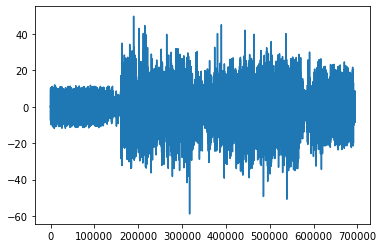

In [308]:
plt.plot(f0)

In [309]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print(A.shape, n_cameras, n_points)

(694346, 192627) 52 64053


### Optimization

Scipy has existing functions for optimization that we can make use of. Write a sentence about the method that is used for optimization

In [310]:
import time
from scipy.optimize import least_squares

#### ‘trf’ : Trust Region Reflective algorithm is suitable for large sparse problems with bounds. Generally it is robust method.

In [311]:
t0 = time.time()
# So far: method='lm'
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-8, xtol=1e-8, gtol=1e-8, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9420e+06                                    1.37e+18    
       1             11         5.9420e+06      0.00e+00       0.00e+00       1.37e+18    
`xtol` termination condition is satisfied.
Function evaluations 11, initial cost 5.9420e+06, final cost 5.9420e+06, first-order optimality 1.37e+18.


In [312]:
params = res.x

new_camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
new_points_3d = params[n_cameras * 9:].reshape((n_points, 3))

### Plot Optimised Points

In [313]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_points_3d)
o3d.visualization.draw_geometries([pcd])

Setting `scaling='jac'` was done to automatically scale the variables and equalize their influence on the cost function (clearly the camera parameters and coordinates of the points are very different entities). This option turned out to be crucial for successfull bundle adjustment.

In [314]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 34 seconds


Now let's plot residuals at the found solution:

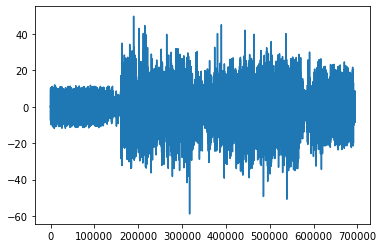

In [315]:
plt.plot(res.fun)

We see much better picture of residuals now, with the mean being very close to zero. There are some spikes left. It can be explained by outliers in the data, or, possibly, the algorithm found a local minimum (very good one though) or didn't converged enough. Note that the algorithm worked with Jacobian finite difference aproximate, which can potentially block the progress near the minimum because of insufficient accuracy (but again, computing exact Jacobian for this problem is quite difficult).

### Project 2- Part B: Submission details -
You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

# Theory

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: An appropriate data structure is necessary that not only stores the 2D-2D correspondance (that is obtained using SIFT or ORB) but also the necesary camera index from which the images are obtained.  For example MATLAB has [imageviewset](https://in.mathworks.com/help/vision/ref/imageviewset.html) data-structure that stores correspondance between keyframes.  
    
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics:  An appropriate data structure is necessary that stores the 3D-2D correspondance of points. For example MATLAB has [worldpointset](https://in.mathworks.com/help/vision/ref/worldpointset.html) that stores this correspondance. 
    
3. `0.5 mark` **Transformations** - `rotate()` function: Why do we use the rodriquez formula? How is this representation different from the standard 3x3 Rotation matrix, why do we use this instead?
    - Ans-3 - Transformations: Interpolation is smooth. Inversion is easier. Only one angle value and one direction vector is required to rotation, its ...  

    
4. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-4 - Transformations: Transformation Matrix belongs to SE(3), which is non commutative, so yes switching the order of translation and rotation will lead to different position. 
        
        
5. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-5 - The value of "m" (in code) in twice the number of observations (because of x y coordinates) , the number of observations is given by shape of camera_ind. In the class notes "N" in the number of 3D points, here although this information is available a given point is observed in multiple camera frames and the actual number of observations is only available in "camera_ind".  
    
6. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 6.1 - Jacobian & Parameters: Because axis angle representation need only 3 elements for rotation. Hence our 9 parameters become camera focal length, 2 camera centers, 3 rotation and 3 translation parameters instead of 12 parameters.
        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 6.2 - Jacobian & Parameters: \
        Unknown paramters according to notes:\
        World points : n_points x 3 \
        Pose : n_cameras x 6  or n_camera x 12 (according to pose parameterization if 6 parameters are used to estimate pose the 6 else 12) \
        Total = World points + Pose
        - Unknown parameters according to the code\
        World points : n_points x 3 \
        Orientation : n_cameras x 9 \
        Total = World points + Orientation
        
            
            
7. `6 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.) For the toy example, you can take something like 3 points all seen from 3 cameras. (You don't actually have to code much, just need to call the existing function) Write that toy example after this cell
    - Ans 6 - Sparsity, Residual Vector & Jacobian: 
        - The first 3 lines of the code calculates the motion jacobian. Therefore it gives the derivative of the residual vector wrt to the 9  parameters of the P matrix.
        - The next 3 lines of the code calculates the structure jacobian. It gives the derivative of the residual vector wrt the 3 axes X,Y,Z .
        - In the code, since the bundle adjustment is sparse, only the jacobian of the points present in that specfic image is calculated and rest are made zero.
         - Since the point $x_{ij}$ only depends on camera j, $\frac{\partial x_{ij}}{\partial P_k} = 0$ for $j \neq k$ 

In [272]:
FILE_NAME = "../questions/problem-52-64053-pre.txt.bz2"
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [273]:
def project(points, camera_params):
    
    rot_vecs = np.array(camera_params[: , 0:3])
    translate = np.array(camera_params[: , 3:6])
    
    rotated_vec = rotate(points, rot_vecs)
    translated_vec = rotated_vec + translate  
    u =  translated_vec

    project_x =  -camera_params[:,6] * ((u[:,0]/u[:,2]))
    project_y =  -camera_params[:,6] * ((u[:,1]/u[:,2]))

    r = np.sqrt(project_x**2 + project_y**2)
    project_x = project_x*(1 + (camera_params[:,7]*r**2) + camera_params[:,8]*r**4)
    project_y = project_y*(1 + (camera_params[:,7]*r**2) + camera_params[:,8]*r**4)

    points_proj = np.stack((project_x, project_y), axis=1)
    return points_proj

def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
 
    params = copy.deepcopy(params)
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])

    return (points_proj - points_2d).ravel()

def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = 6
    n = 36
            
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
            
    return A

[[-209.52354254 -346.54017455]
 [-311.74298163 -352.60829645]
 [ -79.83069045   -8.1419948 ]]
[[-209.61     -346.63    ]
 [-311.67     -352.52    ]
 [ -79.97998    -7.309998]]


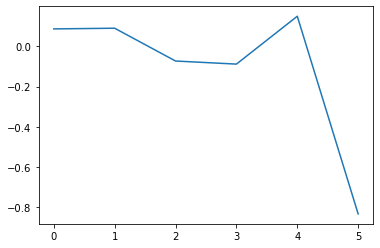

In [274]:
import matplotlib.pyplot as plt

points_3d = (points_3d[0:3])
points_2d = (points_2d[0:3])

point_indices = point_indices[0:3]
camera_indices = (camera_indices[0:3])

# camera_params = camera_params[0:3]

a = camera_params[0:1]
a = np.concatenate((a, camera_params[1:2]), axis=0)
a = np.concatenate((a, camera_params[5:6]), axis=0)
camera_params = a
camera_indices = np.array([0,1,2])

x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

n_cameras = 3
n_points = 3
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

plt.plot(f0)


[[-209.52354254 -346.54017455]
 [-311.74298163 -352.60829645]
 [ -79.83069045   -8.1419948 ]]
[[-209.61     -346.63    ]
 [-311.67     -352.52    ]
 [ -79.97998    -7.309998]]
[[-209.52353735 -346.54017767]
 [-310.69941467 -351.42793189]
 [ -79.83068364   -8.14199159]]
[[-209.61     -346.63    ]
 [-311.67     -352.52    ]
 [ -79.97998    -7.309998]]
[[-8.44847199e+04 -1.39732983e+05]
 [-3.11742986e+02 -3.52608302e+02]
 [-7.98306905e+01 -8.14198472e+00]]
[[-209.61     -346.63    ]
 [-311.67     -352.52    ]
 [ -79.97998    -7.309998]]
[[-209.52354196 -346.54017359]
 [-311.74301671 -352.60829874]
 [ -30.54501299   -3.11530986]]
[[-209.61     -346.63    ]
 [-311.67     -352.52    ]
 [ -79.97998    -7.309998]]
[[-209.01040066 -345.6914667 ]
 [-311.74297649 -352.60830189]
 [ -79.8383468    -8.14277567]]
[[-209.61     -346.63    ]
 [-311.67     -352.52    ]
 [ -79.97998    -7.309998]]
[[-209.52353942 -346.5401694 ]
 [-311.74298091 -352.60828876]
 [ -79.83067973   -8.14200112]]
[[-209.61     

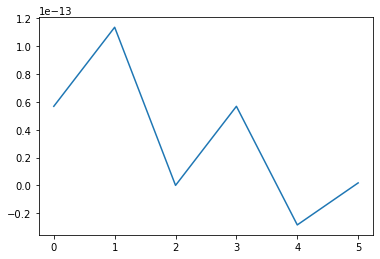

In [275]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
import time
from scipy.optimize import least_squares


t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-8, xtol=1e-8, gtol=1e-8, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()


plt.plot(res.fun)

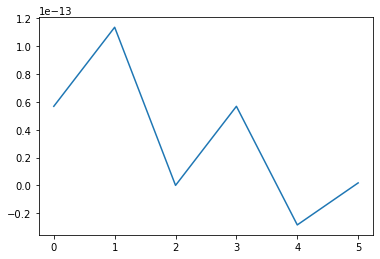

In [276]:
plt.plot(res.fun)

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers).

**Ans 2:**

Given 2 images and K (intrinsic) matrix.

1. First, we will produce the correspondences between two given images using "SIFT" feature descriptor, which will take image as input and provide us correspondences.  
    `sift = cv2.SIFT()` \
    `sift.detectAndCompute(img,None)`

2. Find the essential matrix using "cv2.findEssentialMat() function". We will need left and right image SIFT featured obtained above (pts0) (pts1), focal length from K matrix (focal_length), camera center from K matrix (points_2d) \
`E = cv2.findEssentialMat(pts0, pts1, focal_length, points_2d)` 

3. Decompose Essential Matrix E into R,t using "cv2.recoverPose()" function: \
    `R_t = cv2.recoverPose(E, pts0, pts1, K)`
    Localization is intialized.

4. Solution Selection and Triangulation: \
    Perform direct triangulatation using the four solutions, and check if there is one solution with most points seen with parallax, in front of both cameras and with low reprojection error. Choose it as the solution and intialization for the localization system. 3D point is intializes using traingulation. 

4. Find Projection Matrix P = K[R |t] . \
   Use X = $P^{-1}$x to obtain X in 3d. 
